In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
MVN_4000_MASTER = np.load('/home/ali/Desktop/Pulled_Github_Repositories/NNPDF_Uncertainty/master_version/samples/MVN_4000_MASTER.npy')
MVN_4000_MASTER, MVN_4000_MASTER.shape

(array([[ 0.16080536,  0.08426761, -0.12904368, ...,  4.79523643,
          1.92292986,  9.96338941],
        [ 0.16272652,  0.09032648, -0.12885639, ...,  4.76822093,
          1.62300266,  9.62932675],
        [ 0.1606133 ,  0.0901863 , -0.1286685 , ...,  4.79419151,
          1.4766966 ,  9.71338997],
        ...,
        [ 0.16362296,  0.05545325, -0.12706176, ...,  4.82775024,
          1.55781506, 10.05586116],
        [ 0.16351884,  0.08132231, -0.12650478, ...,  4.77694772,
          1.61214273,  9.4916122 ],
        [ 0.15934977,  0.06089304, -0.12663557, ...,  4.78704589,
          1.38782882,  9.70478093]]),
 (4000, 14))

In [3]:
for i in range(MVN_4000_MASTER.shape[0]):
    print('first point', MVN_4000_MASTER[i,:])
    break

first point [ 0.16080536  0.08426761 -0.12904368  1.02620895 -0.07815834 -0.38075752
  0.80798823 10.13182949  4.9098054   5.40227428  7.07814101  4.79523643
  1.92292986  9.96338941]


We see that this multivariate normal is a 2d array of size $N_{samples}\times N_{parameters}$ where above $N_{samples}=4,000, \ N_{parameters}=14$. But we want the multivariate gaussinan as a single number for each parameter set (for each point), since for a vector $z$, the multivariate normal is 
$$f(z ; \mu, \Sigma)=(2 \pi)^{-\left(\frac{N}{2}\right)} \operatorname{det}(\Sigma)^{-\frac{1}{2}} \exp \left(-.5(z-\mu)^{T} \Sigma^{-1}(z-\mu)\right)$$

In [4]:
COV_MASTER= np.load('/home/ali/Desktop/Pulled_Github_Repositories/NNPDF_Uncertainty/master_version/samples/COV_MASTER.npy')
params_MASTER= np.load('/home/ali/Desktop/Pulled_Github_Repositories/NNPDF_Uncertainty/master_version/samples/params_MASTER.npy')
COV_MASTER[0], params_MASTER[0]

(array([ 4.45e-06,  3.44e-06,  2.25e-06,  2.27e-06, -5.33e-06,  1.28e-06,
         1.23e-06,  3.32e-05, -2.41e-06, -2.81e-06,  5.41e-06, -9.82e-07,
        -2.68e-05,  2.50e-05]),
 0.16126)

In [5]:
def f(MVN, mu, sigma):
    """
    The density function of multivariate normal distribution.
    N = size of the mean vector, or number of parameter points (14)
    MVN = the 2D MV Gaussian function
    sigma = the covariance matrix from our best-fit values
    """

    MVN_per_point_l=[]
    for i in range(MVN.shape[0]):
        #z = np.atleast_2d(z)
        z = MVN[i,:]


        N = z.size

        temp1 = np.linalg.det(sigma) ** (-1/2)
        temp2 = np.exp(-.5 * (z - mu).T @ np.linalg.inv(sigma) @ (z - mu))
        MVN_per_point = (2 * np.pi) ** (-N/2) * temp1 * temp2
        MVN_per_point_l.append(MVN_per_point)
    return np.array(MVN_per_point_l)

In [6]:
MVN_per_point_l = f(MVN_4000_MASTER, params_MASTER, COV_MASTER); MVN_per_point_l

array([2.18574405e+15, 1.95225780e+14, 1.79273040e+14, ...,
       1.40217180e+15, 2.61533561e+13, 2.05068388e+12])

In [7]:
MVN_per_point_l.shape

(4000,)

### load $\chi^2$ array

In [8]:
chi2_array_ALL_DATA_4k = np.load('/home/ali/Desktop/Pulled_Github_Repositories/NNPDF_Uncertainty/master_version/local/ALL_DATA_5k/chi2_array_ALL_DATA_4k.npy')
chi2_array_ALL_DATA_4k, chi2_array_ALL_DATA_4k.shape

(array([ 4106.6131685 ,  4159.59946762,  4092.91292611, ...,
        11334.20576305,  4006.2238563 , 50915.37039728]),
 (4000,))

(array([ 4106.6131685 ,  4159.59946762,  4092.91292611, ...,
        11334.20576305,  4006.2238563 , 50915.37039728], dtype=float128),
 52249.640608373186385,
 2743239.3165318313138)

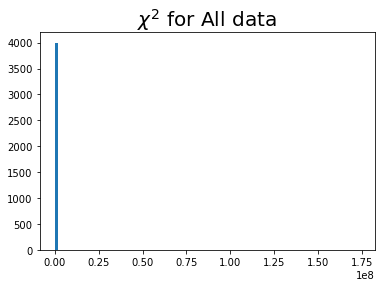

In [11]:
#to avoid overflow take data type as float 128 to handle exponentiation
chi2_array_ALL_DATA_4k = chi2_array_ALL_DATA_4k.astype(np.float128)
MVN_4000_MASTER = MVN_4000_MASTER.astype(np.float128)
plt.hist(chi2_array_ALL_DATA_4k, bins=100)
plt.title('$\chi^2$ for All data', fontsize=20)
chi2_array_ALL_DATA_4k, np.mean(chi2_array_ALL_DATA_4k), np.std(chi2_array_ALL_DATA_4k)

In [12]:
chi2_array_ALL_DATA_4k.mean(), chi2_array_ALL_DATA_4k.std()

(52249.640608373186385, 2743239.3165318313138)

In [15]:
chi2_array_ALL_DATA_4k.min(), chi2_array_ALL_DATA_4k.max(), chi2_array_ALL_DATA_4k.max()/chi2_array_ALL_DATA_4k.min()

(2730.4583091523440999, 173515359.48727497458, 63548.071364305823156)

$\chi^2$ value is expected to be around $~N_{DOF} = 4000-14$

If we do the same method of calculating the weights we run into this problem of getting zeros for the weights since the $\chi^2$ values are really large. But recall that the weights are 

$$w_k^i = \frac{L(\theta)}{L'(\theta)} = \frac{N_{samples} exp^{-\frac{1}{2} (\chi_k ^2 - E[\chi^2])}}{\mathcal{N}(\theta_i;\mu_i, \sigma_i) \ \sum_{k=1}^{N_{samples}} w_k}$$

And we don't care about the overall large constant that is multiplying all the weights, we only care about the differences in weights between the data points. Therefore we can take the log of both sides

$$log w_k^i = log \frac{L(\theta)}{L'(\theta)} = log L(\theta) - log L'(\theta) = log [N_{samples} exp^{-\frac{1}{2} (\chi_k ^2 - E[\chi^2])} ] - log[ \mathcal{N}(\theta_i;\mu_i, \sigma_i) \ \sum_{k=1}^{N_{samples}} w_k] \ \ \ \ \ \ (1)$$mu

$log w = -\frac{1}{2} [\chi^2 - (z-\mu)^{T} \Sigma^{-1}(z-\mu) ]$

Define 

second term = $(z-\mu)^{T} \Sigma^{-1}(z-\mu)$

(array([  84.,  676., 1176.,  996.,  610.,  304.,  108.,   31.,   10.,
           5.]),
 array([ 1.70552097,  5.51187541,  9.31822984, 13.12458428, 16.93093872,
        20.73729316, 24.5436476 , 28.35000204, 32.15635647, 35.96271091,
        39.76906535], dtype=float128),
 <BarContainer object of 10 artists>)

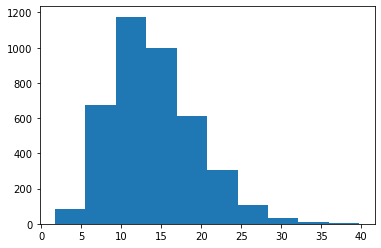

In [10]:
# z = MVN_per_point_l
mu = params_MASTER
sigma = COV_MASTER
second_term_l = []
for i in range(MVN_4000_MASTER.shape[0]):
    second_term = (MVN_4000_MASTER[i,:] - mu).T @ np.linalg.inv(sigma) @ (MVN_4000_MASTER[i,:] - mu)
    second_term_l.append(second_term)
plt.hist(np.array(second_term_l))# second term dist is much narrower, which is what we expect

Let's look at the $\chi^2$ distribution within $2\sigma$ around the best fit  values of the parameters.

In [42]:
list_of_tuples = []; 
chi2_within_1_sigma=[] #np.empty((4000,14))
for i in range(14):
    param_list_i=[]
#     weight_list_i = []
    chi2_list_param_i=[]
    for k in range(4000):
        param_value = MVN_4000_MASTER[k, i] #at the kth point, for parameter i
        
        std_MVN_value = np.std(MVN_4000_MASTER[k,:])
        mean_MVN_value = np.mean(MVN_4000_MASTER[k,:])
        if (param_value > (mean_MVN_value - 1*std_MVN_value)) and (param_value < (mean_MVN_value + 1*std_MVN_value)):
            #if weight_value < (mean_weight + 4*std_weight_value):

            param_list_i.append(param_value)
            chi2_list_param_i.append(chi2_array_ALL_DATA_4k[k])
    chi2_within_1_sigma.append(chi2_list)
            #chi2_within_1_sigma[k,i] = chi2_array_ALL_DATA_4k[k]
    tuple_i = (param_list_i, chi2_list)
    list_of_tuples.append(tuple_i)
#len(list_of_tuples)                
#list_of_tuples[1]

In [47]:
np.mean(chi2_within_1_sigma[0]), np.mean(chi2_within_1_sigma[2]), np.mean(chi2_within_1_sigma[3])

(54518.25314783853257, 54518.25314783853257, 54518.25314783853257)

Same means of $\chi^2$ for each parameter, as we expect.

Still the weird behavior of the $\chi^2$ values being very large 

Text(0.5, 1.0, '$\\chi^2$ values within $1\\ \\sigma$ of the best-fit values of the parameters')

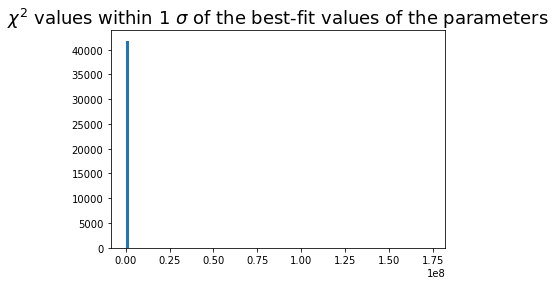

In [49]:
plt.hist(chi2_within_1_sigma[0], bins=100)
plt.title('$\chi^2$ values within $1\ \sigma$ of the best-fit values of the parameters', fontsize=18)

In [24]:
chi2_within_1_sigma=[]
# for i in range(4000+1):
#     chi2_within_1_sigma.append(list_of_tuples[i][1])
    
while i <= 4000:
    chi2_within_1_sigma.append(list_of_tuples[i][1])
    i+=1

IndexError: list index out of range

In [21]:
chi2_filtered = []
for i in range(4000):
    chi2_filtered.append(list_of_tuples[i][0])
plt.hist(np.array(chi2_filtered))

IndexError: list index out of range

In [74]:
chi2_array_ALL_DATA_4k - np.mean(chi2_array_ALL_DATA_4k)

array([-48143.02743987, -48090.04114075, -48156.72768227, ...,
       -40915.43484533, -48243.41675208,  -1334.27021109], dtype=float128)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 3.999e+03]),
 array([-8.67315463e+07, -7.80559142e+07, -6.93802820e+07, -6.07046499e+07,
        -5.20290177e+07, -4.33533856e+07, -3.46777534e+07, -2.60021212e+07,
        -1.73264891e+07, -8.65085693e+06,  2.47752309e+04], dtype=float128),
 <BarContainer object of 10 artists>)

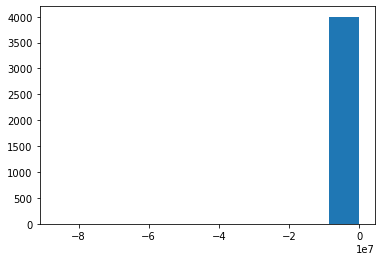

In [76]:
chi2_diff = chi2_array_ALL_DATA_4k - np.mean(chi2_array_ALL_DATA_4k)
w = -0.5*(chi2_diff-np.array(second_term_l))
plt.hist(w)

In [75]:
np.mean(chi2_diff)

-1.2732925824820995331e-14

In [58]:
mean_chi2 = np.mean(chi2_array_ALL_DATA_4k)
#remember to rename diff (no need to take diff at this point)
chi2_diff = chi2_array_ALL_DATA_4k - mean_chi2

log_numerator = -0.5*chi2_diff
log_numerator.shape
# for i in range(14):
#     log_numerator[:,i] =  - 0.5 * (chi2_diff)
# log_numerator #no normalization factor
log_numerator, np.mean(log_numerator)

(array([24071.51371994, 24045.02057037, 24078.36384113, ...,
        20457.71742266, 24121.70837604,   667.13510555], dtype=float128),
 6.3664629124104976654e-15)

In [56]:
log_numerator = log_numerator - np.mean(log_numerator)
log_numerator

array([24071.51371994, 24045.02057037, 24078.36384113, ...,
       20457.71742266, 24121.70837604,   667.13510555], dtype=float128)

(array([ 0.,  0.,  0.,  0.,  1.,  0.,  3.,  1.,  8., 52.]),
 array([-1000000.,  -900000.,  -800000.,  -700000.,  -600000.,  -500000.,
         -400000.,  -300000.,  -200000.,  -100000.,        0.],
       dtype=float128),
 <BarContainer object of 10 artists>)

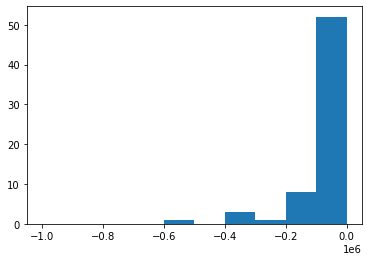

In [62]:
plt.hist(log_numerator, range=(-10**6,0)) #this is equivalent to plt.hist(log_numerator/(e7), range=(-0.01,0))

(array([   5.,   10.,   31.,  108.,  304.,  610.,  996., 1176.,  676.,
          84.]),
 array([19.70262835, 21.60580557, 23.50898279, 25.41216001, 27.31533723,
        29.21851445, 31.12169166, 33.02486888, 34.9280461 , 36.83122332,
        38.73440054], dtype=float128),
 <BarContainer object of 10 artists>)

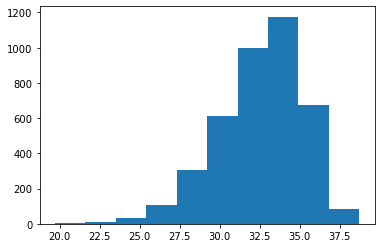

In [63]:
# def log_den(MVN_per_point_l):
#     log_den_l = []
#     for i in range(MVN_per_point_l.shape[0]):
#         log_den = np.log(MVN_per_point_l)

log_den = np.log(MVN_per_point_l)
log_den.shape
plt.hist(log_den)

(array([ 1.,  1.,  2.,  1.,  0.,  5.,  4.,  7., 12., 19.]),
 array([-0.01 , -0.009, -0.008, -0.007, -0.006, -0.005, -0.004, -0.003,
        -0.002, -0.001,  0.   ], dtype=float128),
 <BarContainer object of 10 artists>)

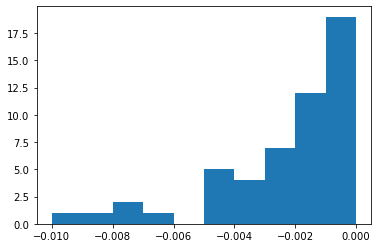

In [51]:
log_RHS = log_numerator - log_den
log_RHS, log_RHS.shape
plt.hist(log_RHS/(1e7), range=(-0.01,0))

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 3.999e+03]),
 array([-8.67315859e+07, -7.80559538e+07, -6.93803216e+07, -6.07046895e+07,
        -5.20290573e+07, -4.33534251e+07, -3.46777930e+07, -2.60021608e+07,
        -1.73265287e+07, -8.65089651e+06,  2.47356437e+04], dtype=float128),
 <BarContainer object of 10 artists>)

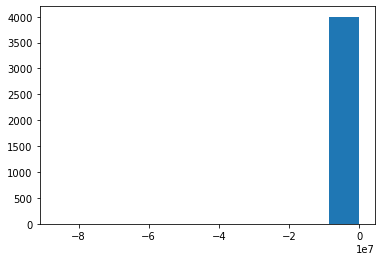

In [35]:
plt.hist(log_RHS)

In [36]:
mean_log_RHS = np.mean(log_RHS)
log_weight =log_RHS- mean_log_RHS
log_weight, log_weight.shape

(array([24068.75203129, 24044.67443657, 24078.10295406, ...,
        20455.39966799, 24123.37242144,   671.34495514], dtype=float128),
 (4000,))

In [41]:
mean_log_RHS

-32.55904404488593718

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 3.999e+03]),
 array([-8.67315534e+07, -7.80559212e+07, -6.93802891e+07, -6.07046569e+07,
        -5.20290247e+07, -4.33533926e+07, -3.46777604e+07, -2.60021283e+07,
        -1.73264961e+07, -8.65086395e+06,  2.47682028e+04], dtype=float128),
 <BarContainer object of 10 artists>)

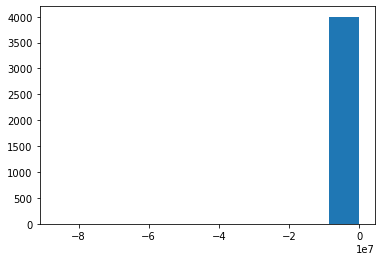

In [37]:
plt.hist(log_weight)

In [38]:
log_weight = MVN_4000_MASTER.shape[0] * log_weight/np.sum(log_weight)
log_weight+

array([8.82129091e+18, 8.81246638e+18, 8.82471806e+18, ...,
       7.49698326e+18, 8.84130949e+18, 2.46050528e+17], dtype=float128)

/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


array([inf, inf, inf, ..., inf, inf, inf], dtype=float128)